# Pennsylvania Bicyclist Crashes 1999 - 2019
### Data from [PennDOT](https://pennshare.maps.arcgis.com/apps/webappviewer/index.html?id=8fdbf046e36e41649bbfd9d7dd7c7e7e)

Note: 2001 data was not linked from that site and PennDOT so far has not been willing to provide it. 1999 data was available until August 2020 but was removed after PennDOT added 2019 data because they provide a total of 20 years.

## Injury Severity Model

#### Import necessary libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#### Read processed data.

In [2]:
person = pd.read_csv('../data/person.csv')
bicycles = pd.read_csv('../data/bicycles.csv')
others = pd.read_csv('../data/others_involved.csv')
roadway = pd.read_csv('../data/roadway.csv')
crashes = pd.read_csv('../data/crashes.csv')

C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7,8,11,12,16,17,18,21,23,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,6,11,13,20,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,6,11,13,14,17,19,24,25,28,29,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (16) have mixed types. Specify dtype 

### Create a flat analysis file by merging processed data.

In [3]:
# combine bicycle and bicyclist data and check dimensions
bicyclists = pd.merge(bicycles,person,on=['CRN','UNIT_NUM'])
bicyclists.shape

(30145, 70)

In [4]:
# add in crash data and check dimensions
bicyclists = pd.merge(bicyclists,crashes,on=['CRN'])
bicyclists.shape

(30145, 171)

In [5]:
# combine data for mvs involved and persons in the mv, keeping only the driver (not passengers)
motorists = pd.merge(others,person,on=['CRN','UNIT_NUM'])
mask = (motorists.PERSON_TYPE == "Driver")
motorists = motorists[mask]
motorists.shape

(29140, 80)

In [ ]:
# ok if 2 bicyclists are involved, but what about 2 motorists? we will be counting injuries twice
# bicyclists = pd.merge(bicyclists,motorists,on=['CRN','UNIT_NUM'], suffixes =('_b','_m') )

In [21]:
bicyclists.INJ_SEVERITY.value_counts()

Possible Injury             14251
Suspected Minor injury       6829
Injury/ Unknown Severity     5778
Suspected Serious injury     1647
Unknown if Injured            897
Not injured                   418
Killed                        325
Name: INJ_SEVERITY, dtype: int64

In [36]:
bicyclists.COLLISION_TYPE.value_counts()

Angle                        20901
Sideswipe (same dir.)         3237
Rear-end                      1832
Head-on                       1513
Hit pedestrian                1452
Sideswipe (Opposite dir.)      824
Other or Unknown               135
Non-collision                   97
Backing                         88
Hit fixed object                66
Name: COLLISION_TYPE, dtype: int64

In [30]:
bicyclists['midblock'] = bicyclists.INTERSECT_TYPE.apply(lambda x: 1 if x =='Mid-block' else 0)

bicyclists['midblock'].value_counts()

In [27]:
bicyclists['inj_KA'] = bicyclists.INJ_SEVERITY.apply(lambda x: 1 if x in ['Killed','Suspected Serious injury'] else 0)

bicyclists['inj_KA'].value_counts()

In [37]:
bicyclists.DVR_PRES_IND.value_counts()

Driver Operated Vehicle    23066
Unknown                     6480
No Driver                    429
Hit and run                  100
Driver Fled Scene             59
Name: DVR_PRES_IND, dtype: int64

In [38]:
bicyclists['HitRun'] = bicyclists.DVR_PRES_IND.apply(lambda x: 1 if x in ['Hit and run','Driver Fled Scene'] else 0)

In [43]:
bicyclists['HitRun'].value_counts()

0    29986
1      159
Name: HitRun, dtype: int64

In [50]:
bicyclists.URBAN_RURAL.value_counts()

Urban        22499
Rural         4098
Urbanized     2387
Name: URBAN_RURAL, dtype: int64

In [132]:
bicyclists['Rural'] = bicyclists.URBAN_RURAL.apply(lambda x: 1 if x =='Rural' else 0)

In [133]:
bicyclists['Rural'].value_counts()

0    26047
1     4098
Name: Rural, dtype: int64

In [119]:
bicyclists.LOCATION_TYPE.value_counts()

Not applicable             27452
Driveway or Parking Lot     2278
Ramp                         147
Bridge                        91
Underpass                     75
Cross over related            18
Ramp and bridge               14
Tunnel                         4
Toll Booth                     2
Name: LOCATION_TYPE, dtype: int64

In [120]:
bicyclists['Driveway'] = bicyclists.LOCATION_TYPE.apply(lambda x: 1 if x =='Driveway or Parking Lot' else 0)
bicyclists.Driveway.value_counts().sort_index()

In [74]:
# add speed limit using the min. in roadway (since there can be multiple roads at a crash location, 
#     and we don't know which one the bicyclist was on)
bicyclists = pd.merge(bicyclists, roadway.SPEED_LIMIT.groupby(roadway.CRN).min(), on=['CRN'])

In [102]:
bicyclists.SPEED_LIMIT.value_counts().sort_index()

10.0       69
15.0     1089
20.0      490
25.0    16827
30.0      906
35.0     4751
40.0     1089
45.0      911
50.0       49
55.0      749
65.0        3
Name: SPEED_LIMIT, dtype: int64

In [143]:
bicyclists.VEH_POSITION.value_counts().sort_index()

HOV lane                              6
Left lane                           676
Left of trafficway                  837
Left turn lane                      117
Not applicable (for peds.)         1130
Oncoming traffic lane              2441
Other                              5308
Other forward moving lane          1018
Right lane (curb)                 11350
Right of trafficway                1829
Right turn lane                     185
Shoulder left                       459
Shoulder right                     1428
Two-direction center turn lane       44
Unknown                            2125
one lane road                      1148
Name: VEH_POSITION, dtype: int64

In [145]:
bicyclists.BUS_COUNT.value_counts().sort_index()

0    29829
1      314
2        2
Name: BUS_COUNT, dtype: int64

In [144]:
bicyclists.HEAVY_TRUCK_COUNT.value_counts().sort_index()

0    29797
1      348
Name: HEAVY_TRUCK_COUNT, dtype: int64

In [146]:
bicyclists['Bus'] = bicyclists.BUS_COUNT.apply(lambda x: 1 if x >=1 else 0)

In [147]:
bicyclists['Truck'] = bicyclists.HEAVY_TRUCK_COUNT.apply(lambda x: 1 if x >=1 else 0)

In [3]:
bicyclists['PickUp'] = bicyclists.SMALL_TRUCK_COUNT.apply(lambda x: 1 if x >=1 else 0)

In [151]:
bicyclists.PC_HLMT_IND.value_counts().sort_index()

         5
N    12329
U    12966
Y     3474
Name: PC_HLMT_IND, dtype: int64

In [153]:
bicyclists['Helmet'] = bicyclists.PC_HLMT_IND.apply(lambda x: 1 if x == "Y" else 0)

In [162]:
def recode_age(x):
    if  x  <= 9:
        return 'Less than 10' 
    elif x >= 10 and x <=14:
        return '10–14'
    elif x >= 15 and x <=19:
        return '15-19'
    elif x >= 20 and x <=29:
        return '20-29'  
    elif x >= 30 and x <=39:
        return '30–39'
    elif x >= 40 and x <=49:
        return '40-49'
    elif x >= 50 and x <=59:
        return '50–59'
    elif x >= 60 and x <=69:
        return '60-69'    
    elif x >= 70 and x <=98:
        return '70 or more'
    elif x == 99:
        return 'Age unknown'

bicyclists['AgeGroup'] = bicyclists.AGE.apply(recode_age)

bicyclists['AgeGroup'].value_counts().sort_index()

10–14           6544
15-19           4739
20-29           5594
30–39           3143
40-49           2956
50–59           2190
60-69            805
70 or more       324
Age unknown      605
Less than 10    3245
Name: AgeGroup, dtype: int64

In [96]:
def recode_speed(x):
    if  x  >= 50:
        return '50+' 
    elif x in [40,45]:
        return '40-45'
    elif x in [30,35]:
        return '30-35'
    elif x <= 25:
        return '25 or less'

bicyclists['PSL'] = bicyclists.SPEED_LIMIT.apply(recode_speed)

bicyclists['PSL'].value_counts()

In [37]:
bicyclists.ILLUMINATION.value_counts().sort_index()

Dark – no street lights              828
Dark – street lights                4974
Dark – unknown roadway lighting      142
Dawn                                 175
Daylight                           22969
Dusk                                 999
Other                                 34
Unknown (expired)                     24
Name: ILLUMINATION, dtype: int64

In [15]:
def recode_light(x):
    if x == 'Daylight':
        return '1 Day'
    elif  x  == 'Dark – no street lights':
        return 'Dark unlit' 
    elif x in ['Dark – street lights','Dark – unknown roadway lighting']:
        return 'Dark'
    elif x == 'Dusk':
        return 'Dusk'
    elif x == 'Dawn':
        return 'Dawn'  
    else: 
        return '1 Day'
    
bicyclists['Lighting'] = bicyclists.ILLUMINATION.apply(recode_light)

bicyclists['Lighting'].value_counts().sort_index()

1 Day         23027
Dark           5116
Dark unlit      828
Dawn            175
Dusk            999
Name: Lighting, dtype: int64

In [10]:
bicyclists['Female'] = bicyclists.SEX.apply(lambda x: 1 if x == 'F' else 0)

In [11]:
bicyclists['Struck'] = bicyclists.VEH_ROLE_CD.apply(lambda x: 1 if x in ['Struck','Striking and Struck'] else 0)

### Save processed and recoded flat file.

In [4]:
bicyclists.to_csv('../data/bicyclists.csv')

### Run injury severity models.

In [2]:
bicyclists = pd.read_csv('../data/bicyclists.csv')

C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,4,9,12,14,16,19,23,24,27,30,33,51,61,63,65,66,80,81,102,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Model 1. All observations

In [3]:
# set print output to 5 digits (not scientific)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [129]:
# binomial logit using glm - All Observations
formula = 'inj_KA ~  midblock + Struck + Helmet + HitRun + Bus + PickUp + PickUp*midblock + Truck + Truck*midblock + Rural+ Female+ C(AgeGroup) + C(PSL) + C(COLLISION_TYPE) + C(Lighting) + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                24818
Model:                            GLM   Df Residuals:                    24778
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5474.6
Date:                Fri, 16 Oct 2020   Deviance:                       10949.
Time:                        21:58:30   Pearson chi2:                 2.49e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.4320  

In [130]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
np.exp(conf)

,5%,95%,Odds Ratio
Intercept,0.02774,0.03766,0.03232
C(AgeGroup)[T.15-19],0.70537,1.00375,0.84144
C(AgeGroup)[T.20-29],0.59929,0.86460,0.71983
C(AgeGroup)[T.30–39],0.70112,1.05219,0.85890
C(AgeGroup)[T.40-49],0.78925,1.17096,0.96134
C(AgeGroup)[T.50–59],0.87520,1.34037,1.08309
C(AgeGroup)[T.60-69],1.12774,1.99586,1.50027
C(AgeGroup)[T.70 or more],1.12102,2.45562,1.65916
C(AgeGroup)[T.Age unknown],0.60798,1.39368,0.92050
C(AgeGroup)[T.Less than 10],0.82579,1.22978,1.00774


In [4]:
def calc_or():
    # retrieve odds ratios and 95% confidence intervals
    low = np.exp(result.params) - np.exp(result.conf_int()[0])
    high = np.exp(result.conf_int()[1]) - np.exp(result.params)
    all_coef_df = pd.DataFrame({'coef': np.exp(result.params.values[1:]),
#                             'err': err_series.values[1:],
                            'low_err': low.values[1:],
                            'high_err': high.values[1:],
                            'varname': low.index.values[1:]})
    # make nicer looking variable names
    all_coef_df.varname.replace(
    ['C(AgeGroup)[T.15-19]',
     'C(AgeGroup)[T.20-29]',
     'C(AgeGroup)[T.30–39]',
     'C(AgeGroup)[T.40-49]',
     'C(AgeGroup)[T.50–59]',
     'C(AgeGroup)[T.60-69]',
     'C(AgeGroup)[T.70 or more]',
     'C(AgeGroup)[T.Age unknown]',
     'C(AgeGroup)[T.Less than 10]',
     'C(PSL)[T.30-35]',
     'C(PSL)[T.40-45]',
     'C(PSL)[T.50+]',
     'C(COLLISION_TYPE)[T.Backing]',
     'C(COLLISION_TYPE)[T.Head-on]',
     'C(COLLISION_TYPE)[T.Hit fixed object]',
     'C(COLLISION_TYPE)[T.Hit pedestrian]',
     'C(COLLISION_TYPE)[T.Non-collision]',
     'C(COLLISION_TYPE)[T.Other or Unknown]',
     'C(COLLISION_TYPE)[T.Rear-end]',
     'C(COLLISION_TYPE)[T.Sideswipe (Opposite dir.)]',
     'C(COLLISION_TYPE)[T.Sideswipe (same dir.)]',
     'C(Lighting)[T.Dark]',
     'C(Lighting)[T.Dark unlit]',
     'C(Lighting)[T.Dawn]',
     'C(Lighting)[T.Dusk]',
     'C(ALCOHOL_RELATED)[T.Yes]',
     'C(DRUGGED_DRIVER)[T.Yes]',
     'C(SPEEDING_RELATED)[T.Yes]',
     'midblock',
     'Struck',
     'Helmet',
     'HitRun',
     'Bus',
     'PickUp',
     'PickUp:midblock',
     'Truck',
     'Truck:midblock',
     'Rural',
     'Female',
     'Driveway'],
     ['15-19',
     '20-29',
     '30–39',
     '40-49',
     '50–59',
     '60-69',
     '70 or more',
     'Age unknown',
     'Less than 10',
      '30-35 mph (ref: <=25 mph)',
      '40-45 mph (ref: <=25 mph)',
      '50+ mph (ref: <=25 mph)',
     'Backing (ref: Angle)',
     'Head-on (ref: Angle)',
     'Hit fixed object (ref: Angle)',
     'Hit pedestrian (ref: Angle)',
     'Non-collision (ref: Angle)',
     'Other or Unknown (ref: Angle)',
     'Rear-end (ref: Angle)',
     'Sideswipe - opp. dir. (ref: Angle)',
     'Sideswipe - same dir. (ref: Angle)',
     'Dark (ref: Daylight)',
     'Dark unlit (ref: Daylight)',
     'Dawn (ref: Daylight)',
     'Dusk (ref: Daylight)',
     'Alcohol-related (ref: not or unk.)',
     'Drugged driver (ref: not or unk.)',
     'Speeding related (ref: not or unk.)',
     'Midblock (ref: intersection)',
     'Bicyclist struck (ref: striking)',
     'Helmet used (ref: not or unk.)',
     'Hit and run (ref: not)',
     'Bus',
     'Small truck at intersection',
     'Small truck midblock',
     'Large truck at intersection',
     'Large truck midblock',
     'Rural (ref: urban)',
     'Female',
     'Driveway'], inplace=True)
    return all_coef_df                           

In [5]:
def plot_coefs(df,ylabel,xlabel):
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(20, 15))    
    df.plot(y='coef', 
                 x='varname', 
                 kind='barh', 
                 ax=ax, color='none',                   
                 logx = True,
                 xerr=[df.low_err, df.high_err],
                 capsize=8,
                 legend = False)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.scatter(y=pd.np.arange(df.shape[0]), 
               marker='s', s=120, 
               x=df['coef'], color='orange')
    ax.axvline(x=1, linestyle='--', color='r', linewidth=3)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10,subs=(0.2,0.4,0.6,0.8)))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.set_xlim(left=.09)

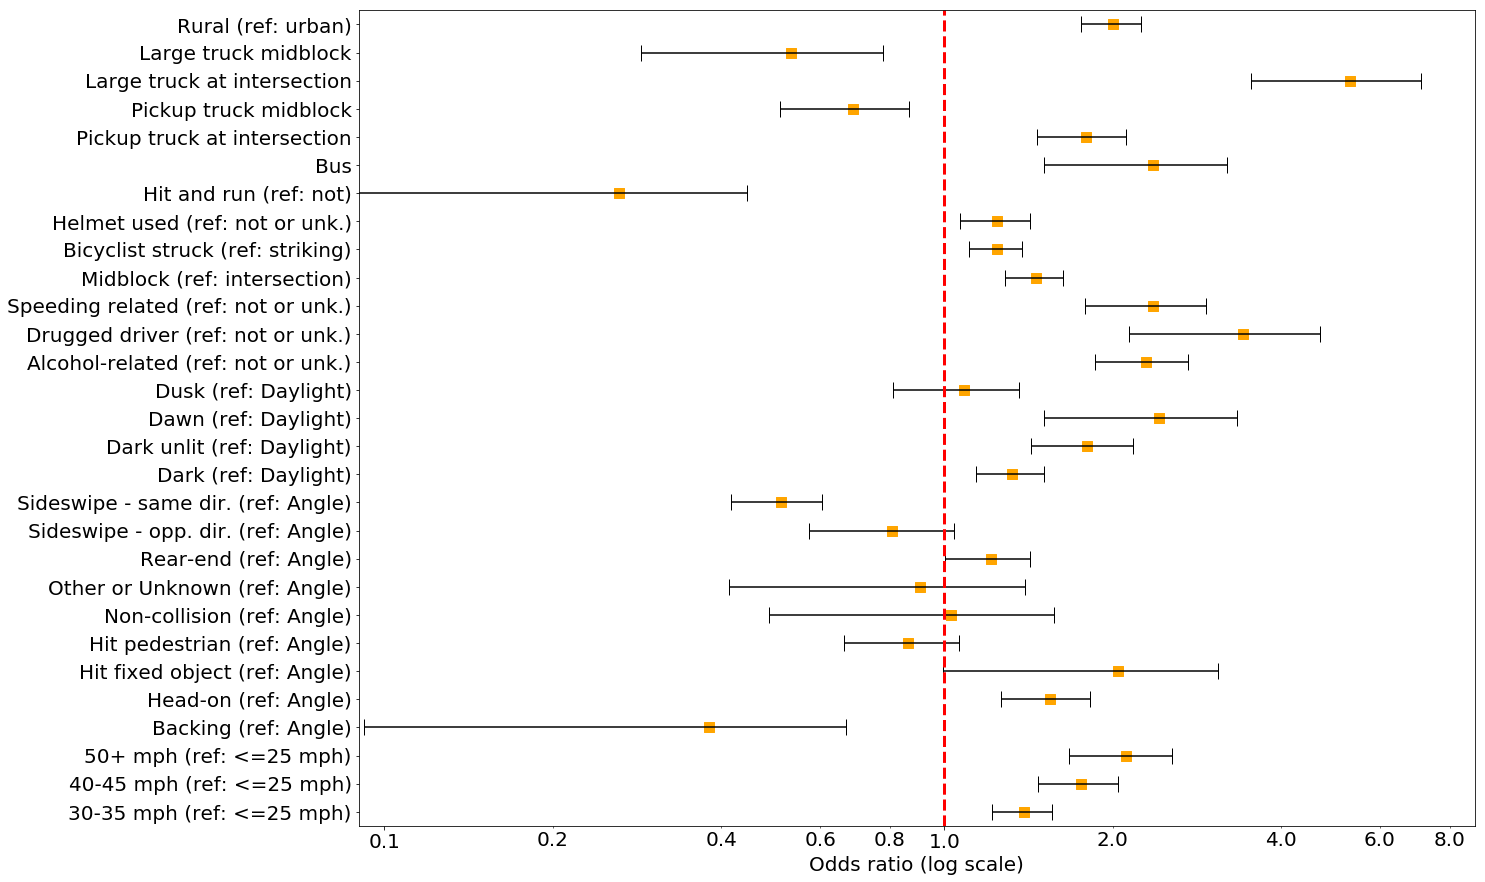

In [133]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
coef_df = all_coef_df[9:38].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
plt.savefig('../images/ORs_all.png', bbox_inches="tight")

#### Model 2 - Urban/urbanized areas with posted speed limit of 30 mph or less only.

In [12]:
mask = ((bicyclists.Rural==0) & (bicyclists.SPEED_LIMIT <= 30))
bicyclists_urb30 = bicyclists[mask]
bicyclists_urb30.shape

(17967, 190)

In [28]:
# share of urban <35 mph based on observations in the model (excluding nulls)
16370/24818

0.6596019018454348

In [14]:
# binomial logit using glm - Urban 30 mph Only Model
formula = 'inj_KA ~ midblock + Struck + Helmet + HitRun + Bus + PickUp + PickUp*midblock + Truck + Truck*midblock + Female + C(AgeGroup) + C(COLLISION_TYPE) + C(Lighting) + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists_urb30, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                16370
Model:                            GLM   Df Residuals:                    16334
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2801.6
Date:                Sat, 17 Oct 2020   Deviance:                       5603.2
Time:                        11:39:37   Pearson chi2:                 1.64e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.3885  

In [15]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
np.exp(conf)

,5%,95%,Odds Ratio
Intercept,0.02750,0.04145,0.03376
C(AgeGroup)[T.15-19],0.56992,0.96963,0.74338
C(AgeGroup)[T.20-29],0.57491,0.95191,0.73977
C(AgeGroup)[T.30–39],0.70811,1.25833,0.94395
C(AgeGroup)[T.40-49],0.81172,1.43853,1.08060
C(AgeGroup)[T.50–59],0.72749,1.40768,1.01196
C(AgeGroup)[T.60-69],0.91798,2.35918,1.47162
C(AgeGroup)[T.70 or more],0.59904,2.65770,1.26178
C(AgeGroup)[T.Age unknown],0.45532,1.47602,0.81980
C(AgeGroup)[T.Less than 10],0.68203,1.18162,0.89772


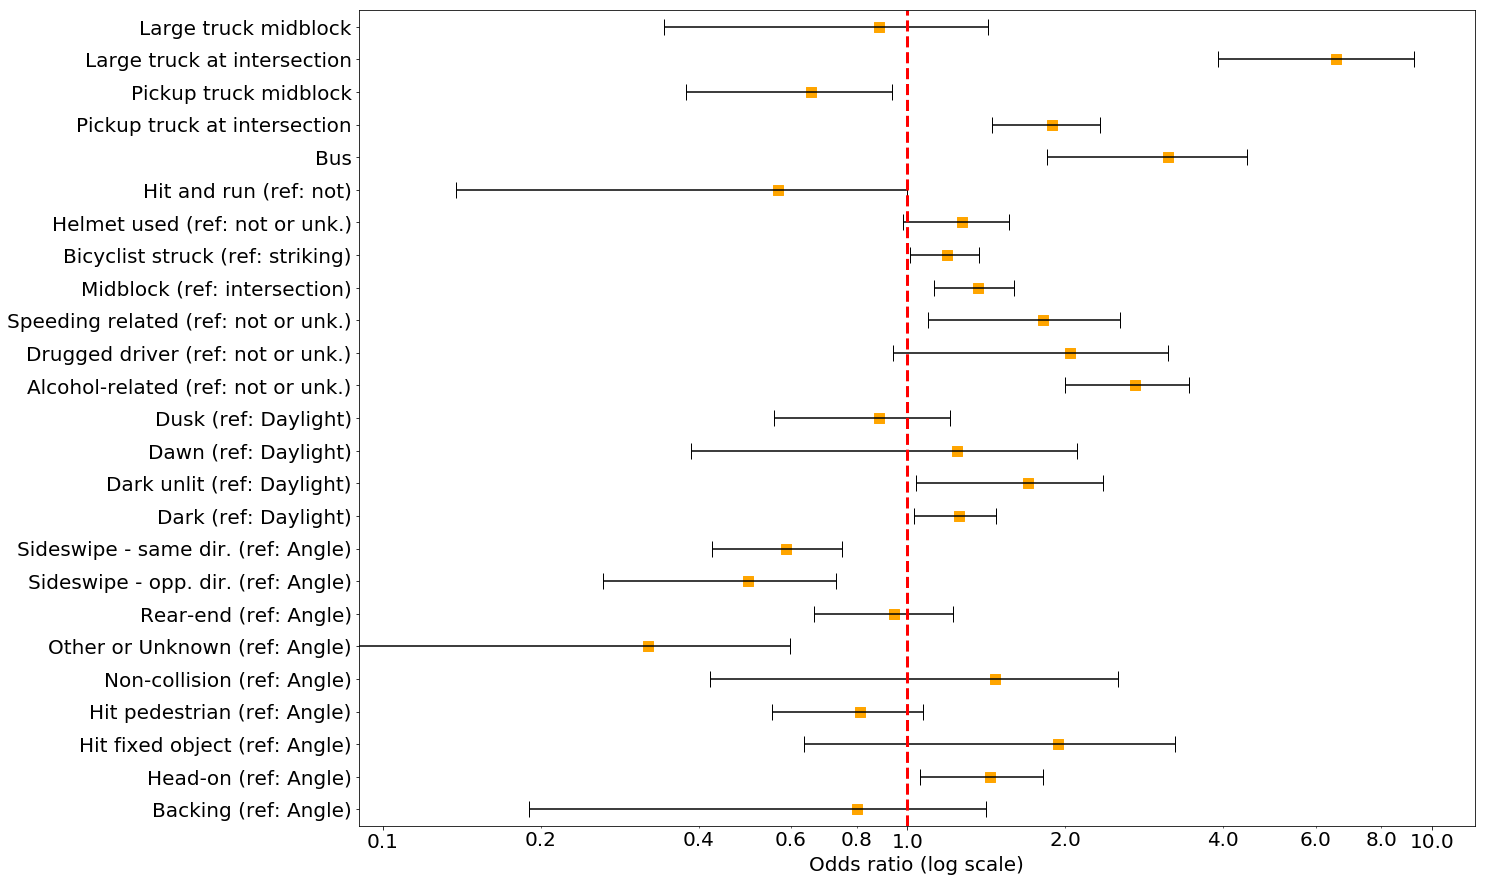

In [16]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
coef_df = all_coef_df[9:34].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
plt.savefig('../images/ORs_urban30.png', bbox_inches="tight")

#### Model 3: 35 mph + areas

In [22]:
# binomial logit using glm - 35 mph or greater
mask = (bicyclists.SPEED_LIMIT > 30)
formula = 'inj_KA ~ midblock + Struck + Helmet + HitRun + Bus + PickUp + PickUp*midblock + Truck + Truck*midblock + Female + C(AgeGroup) + C(COLLISION_TYPE) + C(Lighting) + C(PSL) + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists[mask], family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                 7093
Model:                            GLM   Df Residuals:                     7055
Model Family:                Binomial   Df Model:                           37
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2204.0
Date:                Sat, 17 Oct 2020   Deviance:                       4408.0
Time:                        11:46:26   Pearson chi2:                 7.04e+03
No. Iterations:                    22   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.0611  

In [23]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                                                    5%      95%  Odds Ratio
Intercept                                      0.03595  0.06102     0.04684
C(AgeGroup)[T.15-19]                           0.70102  1.20241     0.91811
C(AgeGroup)[T.20-29]                           0.49228  0.88583     0.66036
C(AgeGroup)[T.30–39]                           0.57662  1.06539     0.78379
C(AgeGroup)[T.40-49]                           0.64241  1.16142     0.86378
C(AgeGroup)[T.50–59]                           0.86059  1.59951     1.17325
C(AgeGroup)[T.60-69]                           0.98045  2.19735     1.46779
C(AgeGroup)[T.70 or more]                      1.26098  3.60938     2.13339
C(AgeGroup)[T.Age unknown]                     0.61267  2.12757     1.14171
C(AgeGroup)[T.Less than 10]                    0.91076  1.82386     1.28883
C(COLLISION_TYPE)[T.Backing]                   0.00000      inf     0.00000
C(COLLISION_TYPE)[T.Head-on]                   1.17884  2.16739     1.59844
C(COLLISION_

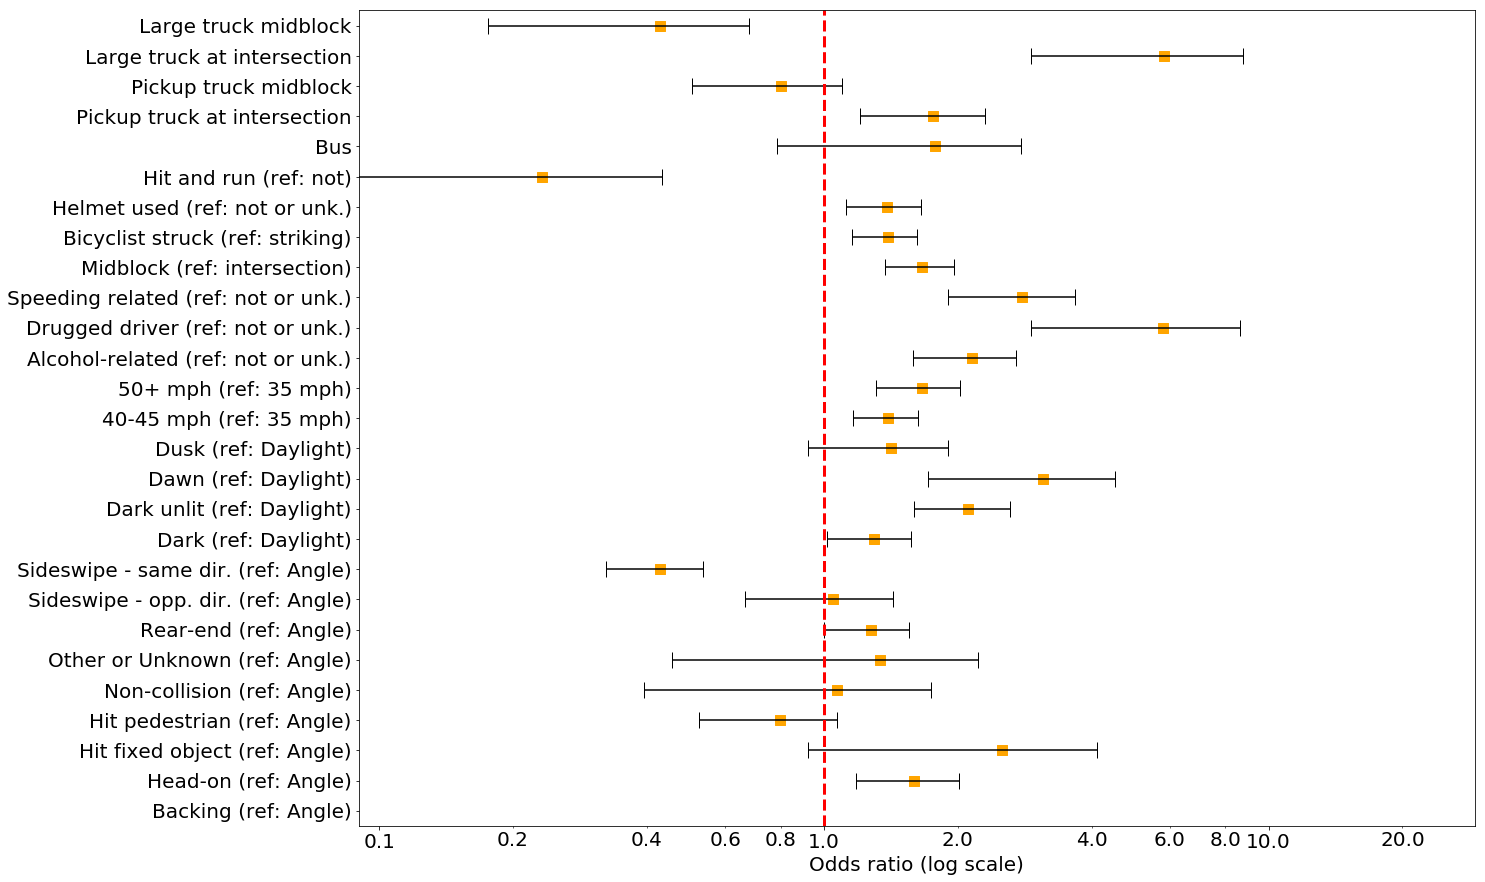

In [27]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
all_coef_df.varname.replace({'40-45 mph (ref: <=25 mph)':'40-45 mph (ref: 35 mph)',
      '50+ mph (ref: <=25 mph)':'50+ mph (ref: 35 mph)'}, inplace=True)
coef_df = all_coef_df[9:36].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
# plt.savefig('../images/ORs_35.png', bbox_inches="tight")

#### Model 4: NTSB variables only, all observations

In [6]:
# binomial logit using glm - All Observations
formula = 'inj_KA ~  midblock + Rural + C(PSL)'
model = smf.glm(formula = formula, data=bicyclists, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                26933
Model:                            GLM   Df Residuals:                    26927
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6455.8
Date:                Tue, 20 Oct 2020   Deviance:                       12912.
Time:                        11:57:14   Pearson chi2:                 2.68e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.0856      0.038    -81.248      0.000      -3.160      -3.011
C(PSL)[T.30-35]     0.3881      0.061

In [7]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                     5%     95%  Odds Ratio
Intercept       0.04243 0.04924     0.04570
C(PSL)[T.30-35] 1.30849 1.66090     1.47420
C(PSL)[T.40-45] 1.88755 2.58672     2.20965
C(PSL)[T.50+]   1.79133 2.76981     2.22747
midblock        1.18954 1.46264     1.31904
Rural           1.79252 2.26677     2.01574


#### Other models

In [10]:
# binomial logit using glm - Urban Only Model
mask = (bicyclists.Rural==0)
formula = 'inj_KA ~ midblock + Struck + Helmet + HitRun + Bus + PickUp + Truck + Truck*midblock + Female + C(AgeGroup) + C(COLLISION_TYPE) + C(Lighting) + Driveway + C(PSL) + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists[mask], family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                21012
Model:                            GLM   Df Residuals:                    20973
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3992.0
Date:                Sat, 10 Oct 2020   Deviance:                       7983.9
Time:                        23:16:20   Pearson chi2:                 2.12e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.4780  

In [12]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                                                    5%      95%  Odds Ratio
Intercept                                      0.02578  0.03697     0.03087
C(AgeGroup)[T.15-19]                           0.59844  0.93465     0.74789
C(AgeGroup)[T.20-29]                           0.61471  0.94012     0.76020
C(AgeGroup)[T.30–39]                           0.73576  1.18015     0.93183
C(AgeGroup)[T.40-49]                           0.81452  1.30119     1.02949
C(AgeGroup)[T.50–59]                           0.89424  1.49672     1.15690
C(AgeGroup)[T.60-69]                           1.10638  2.28482     1.58993
C(AgeGroup)[T.70 or more]                      1.06955  3.06063     1.80928
C(AgeGroup)[T.Age unknown]                     0.62714  1.55986     0.98906
C(AgeGroup)[T.Less than 10]                    0.74441  1.21520     0.95111
C(COLLISION_TYPE)[T.Backing]                   0.09606  1.70892     0.40517
C(COLLISION_TYPE)[T.Head-on]                   1.02225  1.71054     1.32234
C(COLLISION_

In [4]:
# binomial logit using glm - Urban 25 mph Only Model
mask = ((bicyclists.Rural==0) & (bicyclists.SPEED_LIMIT <= 30))
formula = 'inj_KA ~ midblock + Struck + Helmet + HitRun + Bus + PickUp + Truck + Truck*midblock + Female + C(AgeGroup) + C(COLLISION_TYPE) + C(Lighting) + Driveway + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists[mask], family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                16370
Model:                            GLM   Df Residuals:                    16334
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2802.2
Date:                Wed, 14 Oct 2020   Deviance:                       5604.5
Time:                        11:54:45   Pearson chi2:                 1.64e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.3680  

In [57]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
# conf = np.exp(conf)

In [6]:
conf

,5%,95%,Odds Ratio
Intercept,0.028091,0.042273,0.034460
C(AgeGroup)[T.15-19],0.569507,0.968920,0.742837
C(AgeGroup)[T.20-29],0.577134,0.955432,0.742571
C(AgeGroup)[T.30–39],0.711691,1.264618,0.948692
C(AgeGroup)[T.40-49],0.815674,1.445921,1.086002
C(AgeGroup)[T.50–59],0.729800,1.412479,1.015296
C(AgeGroup)[T.60-69],0.924835,2.378527,1.483154
C(AgeGroup)[T.70 or more],0.605079,2.686073,1.274868
C(AgeGroup)[T.Age unknown],0.449805,1.460427,0.810498
C(AgeGroup)[T.Less than 10],0.682566,1.182639,0.898459


In [73]:
err_series = np.exp(result.params) - np.exp(result.conf_int()[0])
all_coef_df = pd.DataFrame({'coef': np.exp(result.params.values[1:]),
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]})

In [116]:
def calc_or():
    # calculate odds ratios and 95% confidence intervals
    params = result.params
    conf = result.conf_int()
    conf['Odds Ratio'] = params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    err_series = np.exp(result.params) - np.exp(result.conf_int()[0])
    all_coef_df = pd.DataFrame({'coef': np.exp(result.params.values[1:]),
                            'err': err_series.values[1:],
                            'varname': err_series.index.values[1:]})
    # make nicer looking variable names
    all_coef_df.varname.replace(
    ['C(AgeGroup)[T.15-19]',
     'C(AgeGroup)[T.20-29]',
     'C(AgeGroup)[T.30–39]',
     'C(AgeGroup)[T.40-49]',
     'C(AgeGroup)[T.50–59]',
     'C(AgeGroup)[T.60-69]',
     'C(AgeGroup)[T.70 or more]',
     'C(AgeGroup)[T.Age unknown]',
     'C(AgeGroup)[T.Less than 10]',
     'C(COLLISION_TYPE)[T.Backing]',
     'C(COLLISION_TYPE)[T.Head-on]',
     'C(COLLISION_TYPE)[T.Hit fixed object]',
     'C(COLLISION_TYPE)[T.Hit pedestrian]',
     'C(COLLISION_TYPE)[T.Non-collision]',
     'C(COLLISION_TYPE)[T.Other or Unknown]',
     'C(COLLISION_TYPE)[T.Rear-end]',
     'C(COLLISION_TYPE)[T.Sideswipe (Opposite dir.)]',
     'C(COLLISION_TYPE)[T.Sideswipe (same dir.)]',
     'C(Lighting)[T.Dark]',
     'C(Lighting)[T.Dark unlit]',
     'C(Lighting)[T.Dawn]',
     'C(Lighting)[T.Dusk]',
     'C(ALCOHOL_RELATED)[T.Yes]',
     'C(DRUGGED_DRIVER)[T.Yes]',
     'C(SPEEDING_RELATED)[T.Yes]',
     'midblock',
     'Struck',
     'Helmet',
     'HitRun',
     'Bus',
     'PickUp',
     'Truck',
     'Truck:midblock',
     'Female',
     'Driveway'],
     ['15-19',
     '20-29',
     '30–39',
     '40-49',
     '50–59',
     '60-69',
     '70 or more',
     'Age unknown',
     'Less than 10',
     'Backing (ref: Angle)',
     'Head-on (ref: Angle)',
     'Hit fixed object (ref: Angle)',
     'Hit pedestrian (ref: Angle)',
     'Non-collision (ref: Angle)',
     'Other or Unknown (ref: Angle)',
     'Rear-end (ref: Angle)',
     'Sideswipe - opp. dir. (ref: Angle)]',
     'Sideswipe - same dir. (ref: Angle)]',
     'Dark (ref: Daylight)',
     'Dark unlit (ref: Daylight)',
     'Dawn (ref: Daylight)',
     'Dusk (ref: Daylight)',
     'Alcohol-related (ref: not or unk.)',
     'Drugged driver (ref: not or unk.)',
     'Speeding related (ref: not or unk.)',
     'Midblock (ref: intersection)',
     'Bicyclist struck (ref: striking)',
     'Helmet used (ref: not or unk.)',
     'Hit and run (ref: not)',
     'Bus (ref: all other veh.)',
     'Pick up or sm. truck (ref: all other veh)',
     'Large truck at inters. (ref: all other veh.)',
     'Large truck midblock',
     'Female',
     'Driveway'], inplace=True)   
    return all_coef_df                           

In [111]:
def plot_coefs(df,ylabel,xlabel,varname):
    fig, ax = plt.subplots(figsize=(18, 20))
    coef_df.plot(y='coef', 
                 x='varname', 
                 kind='barh', 
                 ax=ax, color='none', 
                 logx = True,
                 xerr='err', 
                 legend = False)
#     ax.errorbar(x='varname', y='Odds Ratio', yerr='5%', fmt='o')
    ax.set_xscale('log')
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.scatter(y=pd.np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               x=coef_df['coef'], color='orange')
    ax.axvline(x=1, linestyle='--', color='r', linewidth=3)
#     ax.set_xticks([0, 1, 10])
    plt.tick_params(axis='x', which='minor')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.xaxis.set_ticks_position('none')
#     _ = ax.set_xticklabels(varname,rotation=0, fontsize=16)
    plt.rcParams.update({'font.size': 20})

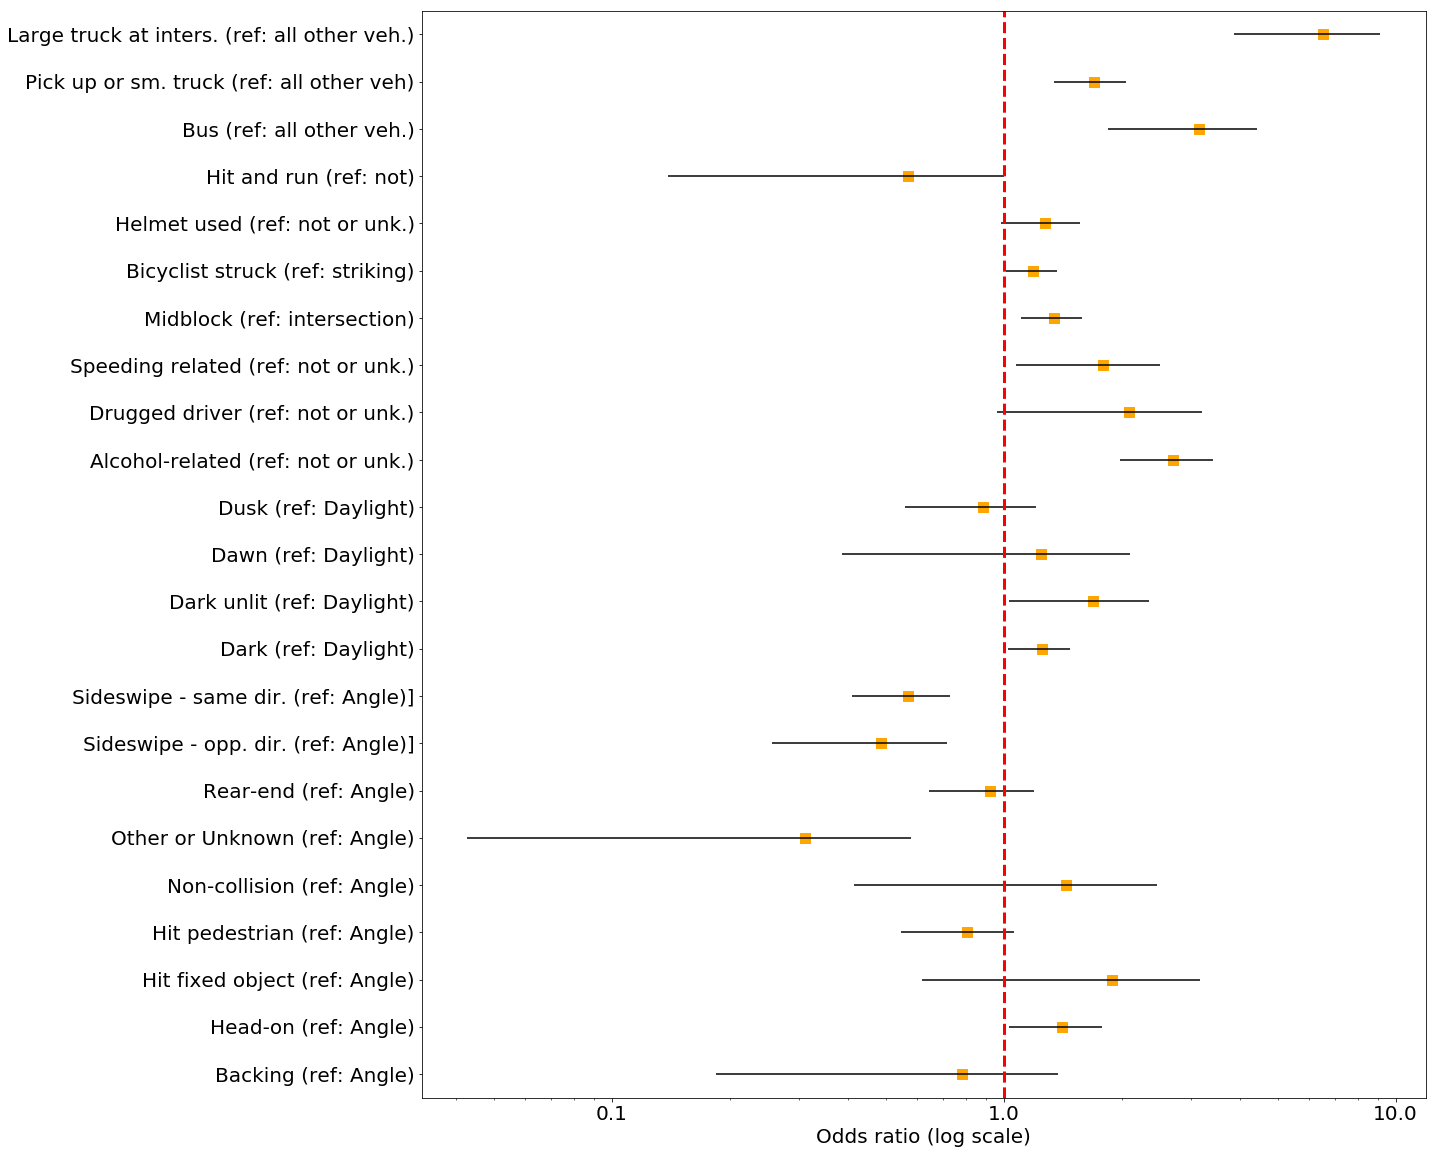

In [112]:
# Plot coefficients and CI on log scale
coef_df = all_coef_df[9:32].copy()
ylabel=''
xlabel='Odds ratio (log scale)'

plot_coefs(coef_df,ylabel,xlabel,varname)
#plt.savefig('filename.png')

In [113]:
# binomial logit using glm
formula = 'inj_KA ~ midblock + Struck + Helmet + HitRun + Rural + Bus + PickUp + Truck + Truck*midblock + Female + C(AgeGroup) + C(COLLISION_TYPE) + C(Lighting) + Driveway + C(PSL) + C(ALCOHOL_RELATED) + C(DRUGGED_DRIVER) + C(SPEEDING_RELATED)'
model = smf.glm(formula = formula, data=bicyclists, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                24818
Model:                            GLM   Df Residuals:                    24778
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5472.0
Date:                Wed, 14 Oct 2020   Deviance:                       10944.
Time:                        23:06:04   Pearson chi2:                 2.48e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -3.3904  

In [117]:
all_coef_df = calc_or()


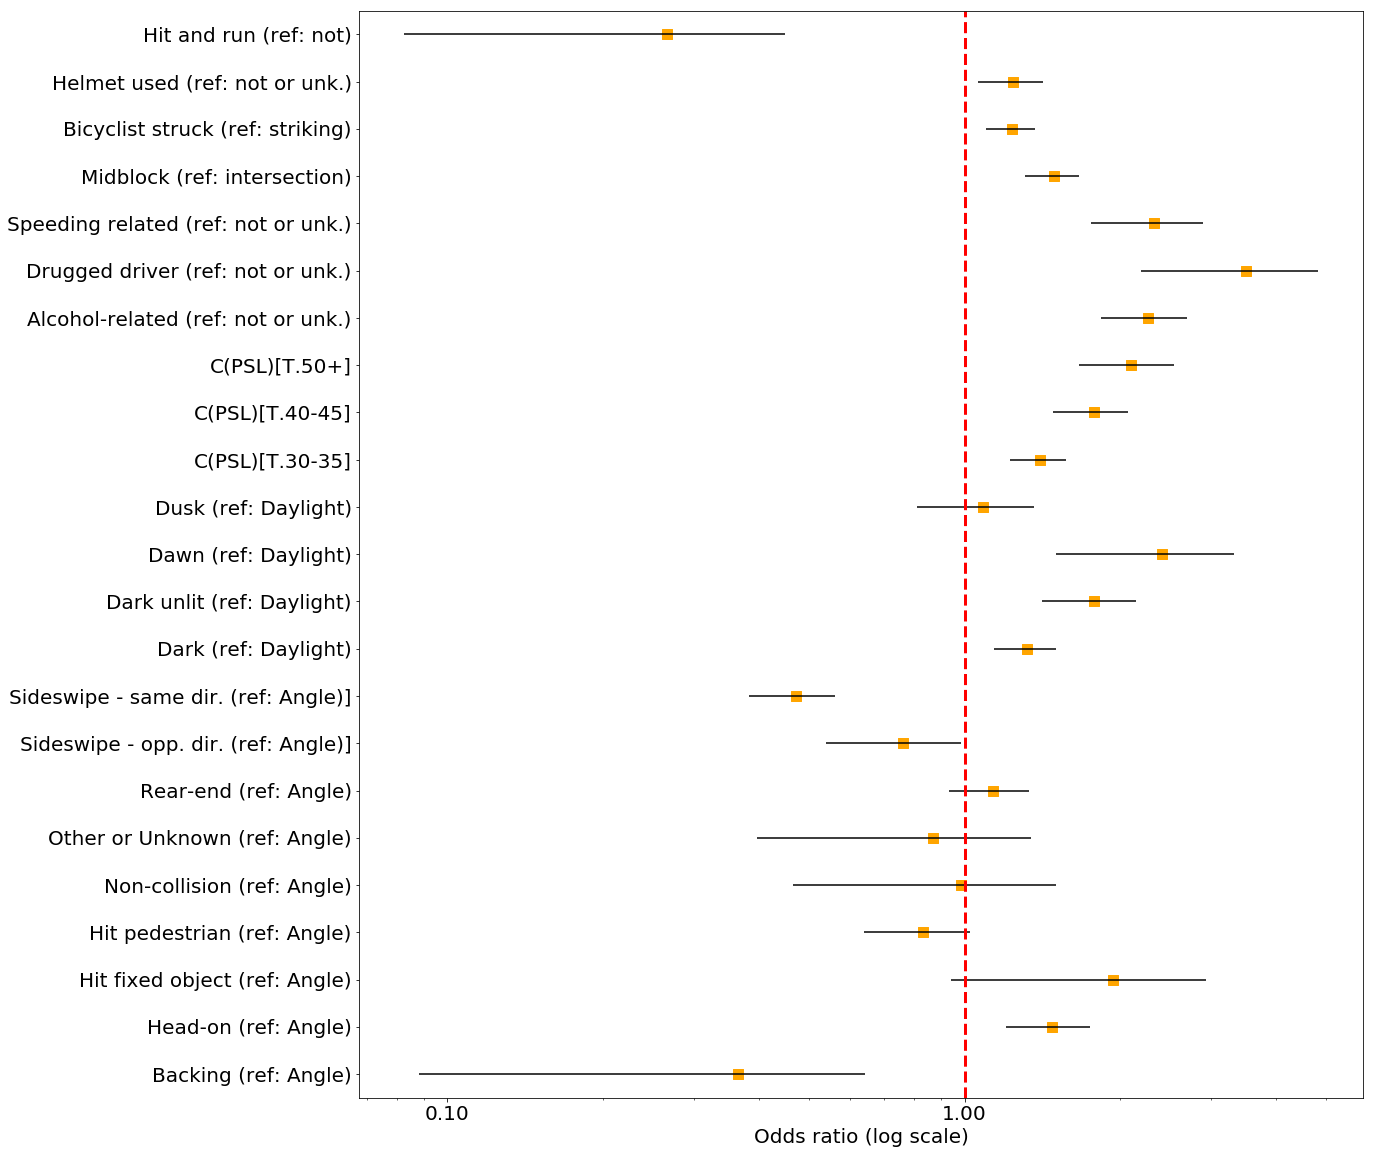

In [119]:
# Plot coefficients and CI on log scale
coef_df = all_coef_df[9:32].copy()
ylabel=''
xlabel='Odds ratio (log scale)'

plot_coefs(coef_df,ylabel,xlabel,varname)
#plt.savefig('filename.png')